## Plot profiles for CTD transects
### applied to fjord thalwegs and ocean transects

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.colors as mcolors
import netCDF4 as nc4
from matplotlib.gridspec import GridSpec
import pandas as pd
from pathlib import Path
import xarray as xr
import cmocean
import rioxarray
from pygc import great_circle
from pygc import great_distance
from pyproj import Proj, transform, Transformer, CRS
import pyresample
import cartopy
import cartopy.mpl.geoaxes
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from scipy.signal import argrelextrema
from scipy.signal import savgol_filter

****

### 1. Obtain data for selected CTDs along transect from binned datasets

In [16]:
# function to take selected CTDs (hard coded AXCTDs and ship-based CTDs) along thalweg of desired fjord
def get_thalweg_ctds(transect_name, year, AXCTD_binned_dir, mooring_locations_dir, ship_CTD_binned_dir):
    
    # open csv file as pandas dataframe that contains mooring lat/lon coordinates
    mooring_locations_df = pd.read_csv(mooring_locations_dir)
    # Set 'Name' column as index on a Dataframe
    mooring_locations_df.set_index("mooring", inplace = True)
    
    # first get list of filenames for desired thalweg (filenames are listed from inshore to offshore)
    if transect_name=='Sverdrup' and year == 2016:
        axctd_file_list = ['2016-09-28T14:56:41',
                           '2016-09-28T13:05:36']
        mooring_coords = mooring_locations_df.loc['sverdrup']
    elif transect_name=='Sverdrup' and year == 2017:
        axctd_file_list = ['2017-10-18T12:09:25',
                           '2017-10-18T12:27:43',
                           '2017-10-18T12:57:24',
                           '2017-10-18T15:39:09']
        mooring_coords = mooring_locations_df.loc['sverdrup']
    elif transect_name=='Sverdrup' and year == 2018:
        axctd_file_list = ['2018-09-05T17:52:25',
                           '2018-09-05T12:21:52']
        ship_ctd_file_list = ['2018-08-23T00:55:11',
                              '2018-08-23T12:04:27',
                              '2018-08-23T16:36:10']
        mooring_coords = mooring_locations_df.loc['sverdrup']
    elif transect_name=='Sverdrup' and year == 2019:
        axctd_file_list = ['2019-09-04T15:59:36',
                           '2019-09-04T14:24:42',
                           '2019-09-04T15:37:30']
        ship_ctd_file_list = ['2019-08-03T15:03:28',
                              # '2019-08-03T16:08:26',
                              '2019-08-03T17:31:28',
                              '2019-08-03T18:40:32',
                              '2019-08-03T20:58:18',
                              '2019-08-06T20:16:01']
        mooring_coords = mooring_locations_df.loc['sverdrup']
    elif transect_name=='Sverdrup' and year == 2020:
        # axctd_file_list = ['2020-09-10T12:27:10', # this was an AXCTD profile at the same place as the OMG Narwhals profile (at mooring site)
        #                  '2020-09-10T12:25:26',
        #                  '2020-09-10T12:13:55',
        #                  '2020-09-11T13:47:58',
        #                  '2020-08-31T13:40:42']
        axctd_file_list = ['2020-09-10T12:25:26',
                         '2020-09-10T12:13:55',
                         '2020-09-11T13:47:58',
                         '2020-08-31T13:40:42']
        ship_ctd_file_list = ['2020-08-09T21:11:17']
        mooring_coords = mooring_locations_df.loc['sverdrup']
    elif transect_name=='Sverdrup' and year == 2021:
        axctd_file_list = ['2021-09-01T13:13:44',
                         '2021-09-01T13:21:11',
                         '2021-09-01T13:30:52',
                         '2021-09-02T14:14:55',
                         '2021-09-02T14:07:07']
        mooring_coords = mooring_locations_df.loc['sverdrup']
    elif transect_name=='Sverdrup (long)' and year == 2021:
        axctd_file_list = ['2021-09-01T13:13:44',
                         '2021-09-01T13:21:11',
                         '2021-09-01T13:30:52',
                         '2021-09-02T14:14:55',
                         '2021-09-02T14:07:07',
                         '2021-09-01T16:43:25',
                         '2021-09-02T14:58:34',
                         '2021-09-02T14:51:45']
        mooring_coords = mooring_locations_df.loc['sverdrup']
    # KONG OSCAR --------------------------------------------------------------
    elif transect_name=='Kong Oscar' and year == 2016:
        axctd_file_list = ['2016-09-28T15:14:57',
                         '2016-09-28T15:19:50']
        mooring_coords = mooring_locations_df.loc['kongoscar19']
    elif transect_name=='Kong Oscar' and year == 2017:
        axctd_file_list = ['2017-10-18T11:48:21',
                         '2017-10-18T12:47:22',
                         '2017-10-18T15:45:26']
        mooring_coords = mooring_locations_df.loc['kongoscar19']
    elif transect_name=='Kong Oscar' and year == 2018:
        axctd_file_list = ['2018-09-10T17:02:22',
                           '2018-09-11T14:16:23',
                           '2018-09-11T14:19:53',
                           '2018-09-05T18:00:23',
                           '2018-09-05T12:15:28']
        ship_ctd_file_list = ['2018-08-24T11:33:38']
        mooring_coords = mooring_locations_df.loc['kongoscar19']
    elif transect_name=='Kong Oscar' and year == 2019:
        axctd_file_list = ['2019-09-04T16:39:56',
                         '2019-09-04T16:34:15',
                         '2019-09-04T15:50:58',
                         '2019-09-04T15:44:30']
        # ship_ctd_file_list = ['2019-08-04T15:15:09',
        #                       '2019-08-04T18:22:33',
        #                       '2019-08-04T16:55:26']
        # first two timestamps are at the same thalweg location - take mooring loc profile here:
        ship_ctd_file_list = ['2019-08-04T15:15:09',
                              '2019-08-04T16:55:26']
        mooring_coords = mooring_locations_df.loc['kongoscar19']
    elif transect_name=='Kong Oscar' and year == 2020:
        # axctd_file_list = ['2020-09-10T12:49:49',
        #                  '2020-09-10T12:48:22',
        #                  '2020-09-10T12:39:55',
        #                  '2020-09-10T11:58:37',
        #                  '2020-09-10T12:01:52',
        #                  '2020-09-11T13:37:27']
        axctd_file_list = ['2020-09-10T12:48:22',
                         '2020-09-10T12:39:55',
                         '2020-09-10T11:58:37',
                         '2020-09-10T12:01:52',
                         '2020-09-11T13:37:27']
        ship_ctd_file_list = ['2020-08-10T11:06:56']
        mooring_coords = mooring_locations_df.loc['kongoscar20']
    elif transect_name=='Kong Oscar' and year == 2021:
        axctd_file_list = ['2021-09-01T12:36:38',
                         '2021-09-01T12:40:43',
                         '2021-09-01T12:52:48',
                         '2021-09-02T13:53:47',
                         '2021-09-02T14:00:00']
        mooring_coords = mooring_locations_df.loc['kongoscar20']
    elif transect_name=='Kong Oscar (long)' and year == 2019:
        axctd_file_list = ['2019-09-04T16:39:56',
                         '2019-09-04T16:34:15',
                         '2019-09-04T15:50:58',
                         '2019-09-04T15:44:30',
                         '2019-09-04T15:29:30',
                         '2019-09-04T15:09:49',
                         '2019-08-28T14:53:08']
        mooring_coords = mooring_locations_df.loc['kongoscar19']
    # RINK --------------------------------------------------------------
    elif transect_name=='Rink' and year == 2016:
        axctd_file_list = ['2016-09-28T15:58:51',
                         '2016-09-28T16:08:47']
        mooring_coords = mooring_locations_df.loc['rink']
    elif transect_name=='Rink' and year == 2018:
        axctd_file_list = ['2018-09-10T17:19:15',
                         '2018-09-05T12:04:18']
        ship_ctd_file_list = ['2018-08-25T19:46:31',
                              '2018-08-26T11:58:46',
                              '2018-08-26T17:25:54']
        mooring_coords = mooring_locations_df.loc['rink']
    elif transect_name=='Rink' and year == 2019:
        axctd_file_list = ['2019-09-04T16:57:32',
                         '2019-09-04T17:01:35',
                         '2019-09-04T17:04:28',
                         '2019-09-04T17:20:50']
        ship_ctd_file_list = ['2019-08-05T12:02:56',
                              '2019-08-05T14:17:25']
        mooring_coords = mooring_locations_df.loc['rink']
    elif transect_name=='Rink' and year == 2020:
        axctd_file_list = ['2020-09-10T13:19:31',
                         '2020-09-10T13:22:07',
                         '2020-09-10T13:16:00',
                         '2020-09-10T13:12:55',
                         '2020-09-10T11:47:44',
                         '2020-09-11T13:18:19']
        mooring_coords = mooring_locations_df.loc['rink']
    elif transect_name=='Rink' and year == 2021:
        axctd_file_list = ['2021-08-31T16:47:31',
                         '2021-08-31T16:52:09',
                         '2021-08-31T16:40:54',
                         '2021-08-31T16:33:14',
                         '2021-08-31T16:30:16',
                         '2021-08-31T16:23:03']
        mooring_coords = mooring_locations_df.loc['rink']
    elif transect_name=='Fisher Islands' and year == 2020:
        axctd_file_list = []
        mooring_coords = mooring_locations_df.loc['fisher']
   
    # open binned datasets for desired year
    filename_axctd = 'OMG_Ocean_AXCTD_Greenland_' + str(year) + '.nc'
    axctds_binned_ds = xr.open_dataset(AXCTD_binned_dir / filename_axctd)
    
    # add 'ship' or 'axctd' coordinate to label how each profile was acquired
    # drop variables for each dataset so that they match in # and name of variables (to combine them)
    ctd_type_ax = ['axctd']*len(axctds_binned_ds.profile)
    axctd_tmp_ds = axctds_binned_ds.assign_coords({"ctd_type": ("profile", ctd_type_ax)}).drop_vars(['profile_time'])
    
    # make ctd filename list a DataArray in order to index the dataset
    index_axctd = xr.DataArray(axctd_file_list, dims=["time"]).astype('datetime64[s]')
    
    # make time a dimensional coordinate so we can index by timestamp
    axctds_ds = axctd_tmp_ds.swap_dims({"profile": "time"})
    
    # select desired CTD profiles from the binned datasets
    axctds_transect_ds = axctds_ds.sel(time=index_axctd)
    
    if year in [2018,2019,2020]: # years when ship-based work was conducted
        if transect_name=='Rink' and year == 2020: ctds_transect_ds = axctds_transect_ds.copy(deep=True)
        else:
            filename_ship_ctd = 'OMG_Narwhals_Ocean_CTD_Greenland_' + str(year) + '.nc'
            ship_ctds_binned_ds = xr.open_dataset(ship_CTD_binned_dir / filename_ship_ctd)
            
            ctd_type = ['ship']*len(ship_ctds_binned_ds.profile)
            ship_tmp_ds = ship_ctds_binned_ds.assign_coords({"ctd_type": ("profile", ctd_type)}).drop_vars(['pressure','potential_temperature','flag'])
            
            index_ship_ctd = xr.DataArray(ship_ctd_file_list, dims=["time"]).astype('datetime64[s]')
            ship_ctds_ds = ship_tmp_ds.swap_dims({"profile": "time"})
            ship_ctds_transect_ds = ship_ctds_ds.sel(time=index_ship_ctd)
            
            if year != 2020: # correct depth for 2018 and 2019
                ship_ctds_transect_ds = ship_ctds_transect_ds.assign_coords(depth=ship_ctds_binned_ds.depth.values+33)
                
            # combine the axctd and ship datasets
            ctds_transect_ds = xr.concat([axctds_transect_ds,ship_ctds_transect_ds],dim='time')
            # ctds_transect_ds = ship_ctds_transect_ds.copy(deep=True) # comment out when you only want to plot OMG Narwhals CTD profiles
    else: ctds_transect_ds = axctds_transect_ds.copy(deep=True)
    
    # returns dataset containing the CTD profiles along the transect
    # it also returns the fjord name and mooring lat/lon coords for future steps
    return(ctds_transect_ds, transect_name, mooring_coords)

### 2. Find closest points along thalweg to CTD locations

Transform CTD coordinates to polar stereographic north EPSG 3413

In [17]:
# function that reprojects lat/lon coordinates to polar north stereographic and adds these new x,y coordinates to the dataset
def transform_projection_to_polar(ctds_transect_ds):
    transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413')
    x, y = transformer.transform(ctds_transect_ds.lat, ctds_transect_ds.lon)
    
    ctds_transect_ds.coords['x'] = (ctds_transect_ds.time.dims, x)
    ctds_transect_ds.coords['y'] = (ctds_transect_ds.time.dims, y)
    
    return ctds_transect_ds

Determine which points along the thalweg line are closest to the AXCTD profile locations

In [18]:
def assign_ctds_to_points_on_transect(transect_csv_dir):
    transect_points_df = pd.read_csv(transect_csv_dir)
    
    # reverse sign of bathymetry so that positive is downward
    # and convert distance from glacier front from meters to km
    transect_points_df.Bed_meters *= -1
    transect_points_df.distance *= 0.001
    
    # calculate maximum seafloor depth
    max_seafloor = round(max(transect_points_df.Bed_meters) + 1)
    
    # determine points along transect that are closest to ctd locations
    ctd_distances_along_transect = []
    
    for i in range(len(ctds_transect_ds_xy.time)):
        profile = ctds_transect_ds_xy.isel(time=i)
        distance = ((transect_points_df['x']-profile.x.values)**2 + (transect_points_df['y']-profile.y.values)**2)**0.5
        
        index = np.argmin(distance)
        x = transect_points_df.distance[index]
        
        ctd_distances_along_transect.append(x)
    
    return ctd_distances_along_transect, max_seafloor, transect_points_df

### 3. Interpolate CTD profiles along thalweg

Create a new dataset with coordinates of `distance` and variables of temperature and salinity for the selected CTD profiles

In [19]:
# new version
def interpolate_ctd_pairs(da_new, distance_of_transect_da):
    # For loop that takes 1) each pair of CTD profiles, 2) a linear interpolation between profiles, 3) extends the deeper CTD profile forward
    for i in range(len(da_new.distance)-1):
        profile_pair = da_new.isel(distance=slice(i,i+2)) # subset two profiles
        # first, fill any gaps in CTD profile
        profile_pair_full = profile_pair.interpolate_na(dim='depth')
        # linear interpolation between profile pair
        profile_pair_interp = profile_pair_full.interp(distance=distance_of_transect_da)
        
        # fill in values of deeper CTD to see full profile ------------------------------------
        # substitute ones for the nans in the data for the short profile
        interp_short_zeros = np.where(profile_pair_interp.values!=np.nan,0,1) # create mask for 'short' interpolation
        interp_short_mask = (profile_pair_interp*interp_short_zeros).fillna(1)
        # fill values using deeper CTD cast for pair of profiles and create 'long' interpolation profile
        tmp = profile_pair_full.ffill(dim='distance').bfill(dim='distance')
        profile_pair_interp_long = tmp.interp(distance=distance_of_transect_da)
        # fill nans with zeros
        interp_long_zeros = profile_pair_interp_long.fillna(0)
        
        # isolate deeper section of the 'long' profile, reduce its length (distance), and combine to short profile
        chunk = (interp_long_zeros*interp_short_mask).where((interp_long_zeros*interp_short_mask)!=0, np.nan)
        if profile_pair.isel(distance=0).max_depth.values > profile_pair.isel(distance=1).max_depth.values:
            distance = profile_pair.isel(distance=0).distance.values
            chunk_select = chunk.sel(distance=slice(distance-1, distance+5)) # cut out as much of the deeper section you want
        else:
            distance = profile_pair.isel(distance=1).distance.values
            chunk_select = chunk.sel(distance=slice(distance-5, distance+1))
        profile_pair_interp_all = profile_pair_interp.combine_first(chunk_select)
        
        # assign tmp to final output DataArray
        if i == 0: da_interp = profile_pair_interp_all.copy(deep=True)
        else: da_interp = da_interp.combine_first(profile_pair_interp_all)
        
        # extend profile 20 km in each direction
        # da_interp_extended = da_interp.ffill(dim='distance', limit=40).bfill(dim='distance', limit=40)
    return da_interp

In [20]:
def interpolate_profile_along_transect(ctds_transect_ds_xy, transect_points_df):
    # add `distance` along transect at which each CTD profile is located as a new coordinate in dataset
    ctds_transect_ds_xy.coords['distance'] = (ctds_transect_ds_xy.time.dims, ctd_distances_along_transect)
    
    # reorder the dataset by ascending distance values
    ctds_transect_ds_xy_sorted = ctds_transect_ds_xy.sortby(ctds_transect_ds_xy.distance)
    
    # distances from glacier front are the values we want to interpolate over
    # make new DataArrays, use 'distance' as one of the dimensions
    temp_da_new = ctds_transect_ds_xy_sorted.temperature.swap_dims({'time':'distance'}).drop(['time','x','y','lat','lon'])
    salt_da_new = ctds_transect_ds_xy_sorted.salinity.swap_dims({'time':'distance'}).drop(['time','x','y','lat','lon'])
    
    density = ctds_transect_ds_xy_sorted.density - 1000
    density_da_new = density.swap_dims({'time':'distance'}).drop(['time','x','y','lat','lon'])
    
    # make DataArray of values you want to interpolate over
    distance_of_transect_da = np.array(transect_points_df.distance)
    
    # interpolation for each dataset
    temp_da_interp = interpolate_ctd_pairs(temp_da_new, distance_of_transect_da)
    salt_da_interp = interpolate_ctd_pairs(salt_da_new, distance_of_transect_da)
    density_da_interp = interpolate_ctd_pairs(density_da_new, distance_of_transect_da)
    
    return temp_da_interp, salt_da_interp, density_da_interp

In [21]:
def nearest_line_bedmachine(lats_swath, lons_swath, data_grid, grid_bedmachine):
    # find nearest neighbor lat/lon values from bedmachine data using normal line lat/lon swaths
    swath = pyresample.geometry.SwathDefinition(lons=lons_swath, lats=lats_swath)
    
    # Determine nearest (w.r.t. great circle distance) neighbour in the grid.
    _, _, index_array, distance_array = pyresample.kd_tree.get_neighbour_info(
        source_geo_def=grid_bedmachine, target_geo_def=swath, radius_of_influence=250,neighbours=1)
    
    # get_neighbour_info() returns indices in the flattened lat/lon grid. Compute the 2D grid indices:
    index_array_2d = np.unravel_index(index_array, grid_bedmachine.shape)
    
    # print("Indices of nearest neighbours:", index_array_2d)
    # print("Longitude of nearest neighbours:", lon_grid[index_array_2d])
    # print("Latitude of nearest neighbours:", lat_grid[index_array_2d])
    # print("Great Circle Distance:", distance_array)
    
    # data_swath = pyresample.kd_tree.resample_nearest(
    #     source_geo_def=grid, target_geo_def=swath, data=data_grid,
    #     radius_of_influence=50000)
    
    # return data_swath, index_array_2d
    return index_array_2d

In [22]:
def get_peak(lon_thalweg_slice, lat_thalweg_slice, line_points_array, azimuth, data_grid, lat_grid_bedmachine, lon_grid_bedmachine, grid_bedmachine):
    # get line (with defined length and # points equal to line_points_array) at specified angle (=azimuth)
    
    line_swath = great_circle(distance=line_points_array, azimuth=azimuth, latitude=lat_thalweg_slice, longitude=lon_thalweg_slice)
    lons_swath = line_swath['longitude']
    lats_swath = line_swath['latitude']
    
    # function that uses lat/lon on from search line (=swath) to get closest lat/lon point and bathymetry value from Bedmachine dataset
    index_array_2d = nearest_line_bedmachine(lats_swath, lons_swath, data_grid, grid_bedmachine)
    
    # index of peak value in line
    index_peak = np.argmax(data_grid[index_array_2d])
    
    lat_ridge = np.array([lat_grid_bedmachine[index_array_2d][index_peak]]) # lat point for peak bathymetry point
    lon_ridge = np.array([lon_grid_bedmachine[index_array_2d][index_peak]]) # lon point for peak bathymetry point
    bathy_ridge = np.array([data_grid[index_array_2d].max()])
    
    ridge_to_thalweg_distance = np.array(great_distance(start_latitude=lat_ridge, start_longitude=lon_ridge,\
                                               end_latitude=lat_thalweg_slice, end_longitude=lon_thalweg_slice)['distance'])
    
    peak_da = xr.DataArray(data=bathy_ridge, dims=['distance'],
                           coords={'distance':ridge_to_thalweg_distance, 'lat':(['distance'],lat_ridge), 'lon':(['distance'],lon_ridge)})
    
    # get search line lat/lons
    lat_line = lat_grid_bedmachine[index_array_2d][:] # lat points for line along which I select the max elevation
    lon_line = lon_grid_bedmachine[index_array_2d][:] # lon points for line along which I select the max elevation
    
    return peak_da, lat_line, lon_line

***

### 4. Plot profile with bathymetry

Function with only transect plotted (not line profiles) for manuscript multipanel plot

In [23]:
def plot_ctd_transect(ctds_transect_ds_xy, transect_points_df, mooring_coords, max_seafloor, output_dir, ridgeline_dir,\
                      transect_name, along_transect_da, density_DA_new_at_interpolation_depths, variable='temperature'):
    """
    `along_transect_da` will be `temp_da_interp` or `salt_da_interp` when function is called
    """
    # provide a maximum depth for the figure (below the bathy line)
    max_depth = 1100
    year = str(ctds_transect_ds_xy.time.values[0])[0:4]

    fig = plt.figure(figsize=(10,4))
    plt.rcParams['font.size'] = 20
    ax = fig.add_subplot(1,1,1)
    
    if variable == 'temperature':
            # C=ax.pcolormesh(along_transect_da.distance,along_transect_da.depth,\
            #                 np.transpose(along_transect_da.values),cmap='RdYlBu_r',vmin=-3,vmax=3)
            levels=np.arange(-1.5,3.2,0.1)
            # levels=np.arange(-0.6,1.2,0.1) # range for mooring profiles (KO)
            # levels=np.arange(-0.5,1.5,0.1) # range for mooring profiles (sverdrup)
            # levels=np.arange(round(along_transect_da.values.max(),1)*-1,round(along_transect_da.values.max(),1)+0.1,0.1)
            C=ax.contourf(along_transect_da.distance,along_transect_da.depth,\
                            np.transpose(along_transect_da.values),cmap='RdYlBu_r',levels=levels,extend='both')
            cbar = plt.colorbar(C, label='Temperature (°C)', ticks=[-1.5,0,1.5,3], ax=ax)
            
            # add contour lines
            cp = ax.contour(density_DA_new_at_interpolation_depths.distance,density_DA_new_at_interpolation_depths.depth,\
                            np.transpose(density_DA_new_at_interpolation_depths.values), levels=[28, 29], colors='black', linewidths=0.6)
            # cp = ax.contour(along_transect_da.distance,along_transect_da.depth,\
            #                 np.transpose(along_transect_da.values), levels=[0], colors='black', linewidths=0.6)
            label_loc = along_transect_da.distance.max() - 20
            manual_locations = [(label_loc, 200),(label_loc, 400)]
            ax.clabel(cp, inline=1, fontsize=16, manual=manual_locations)
    
    if variable == 'salinity':
            # C=ax.pcolormesh(along_transect_da.distance,along_transect_da.depth,\
            #                 np.transpose(along_transect_da.values),cmap=cmocean.cm.haline,vmin=32,vmax=34.75)
            # levels=np.arange(round(along_transect_da.values.min(),1)+0.6,round(along_transect_da.values.max(),1)+0.2,0.1)
            levels=np.arange(32,34.6,0.1)
            # levels=np.arange(33.2,34.1,0.1)  # range for mooring profiles (KO)
            C=ax.contourf(along_transect_da.distance,along_transect_da.depth,\
                            np.transpose(along_transect_da.values),cmap=cmocean.cm.haline,levels=levels,extend='both')
            cbar = plt.colorbar(C, label='Salinity (PSU)', ticks=[32,32.6,33.2,33.8,34.4], ax=ax)
            # add contour lines
            cp = ax.contour(along_transect_da.distance,along_transect_da.depth,\
                            # np.transpose(along_transect_da.values), levels=[33.7,34.1,34.4], colors='black', linewidths=0.6)
                            np.transpose(along_transect_da.values), levels=[33.7], colors='black', linewidths=0.6)
            label_loc = along_transect_da.distance.max() - 25
            # manual_locations = [(label_loc, 100),(label_loc, 200),(label_loc, 400)]
            manual_locations = [(label_loc, 100)]
            ax.clabel(cp, inline=1, fontsize=16, manual=manual_locations)
    
    # add bathymetry layer in gray
    ax3=ax.twinx()
    ax3.fill_between(transect_points_df.distance, transect_points_df.Bed_meters, max_depth, color='k', zorder=2)
    ax3.plot(transect_points_df.distance, transect_points_df.Bed_meters,'k',linewidth=0.3,zorder=2)
    
    # add ridgeline ---------------------------------------------------------
    if transect_name == 'Rink': fjord = 'rink'
    if transect_name == 'Sverdrup': fjord = 'sverdrup'
    if transect_name == 'Kong Oscar': fjord = 'kongoscar'
    
    if "transect" not in transect_name: # plot ridgelines for along-thalweg transects from glacier fronts
        ridgeline_plus_ds = xr.open_dataset(ridgeline_dir + fjord + '_ridgeline_plus.nc')
        ridgeline_minus_ds = xr.open_dataset(ridgeline_dir + fjord + '_ridgeline_minus.nc')

        # plot ridgeline
        # plus in background
        ax3.fill_between(ridgeline_plus_ds.distance/1000, ridgeline_plus_ds.ridgeline_plus.values*(-1), max_depth, color='dimgray', alpha=0.1)
        ax3.plot(ridgeline_plus_ds.distance/1000, ridgeline_plus_ds.ridgeline_plus.values*(-1),'k',linewidth=0.3,zorder=1, alpha=0.5)
        # minus in foreground
        ax3.fill_between(ridgeline_minus_ds.distance/1000, ridgeline_minus_ds.ridgeline_minus.values*(-1), max_depth, color='dimgray', alpha=0.1)
        ax3.plot(ridgeline_minus_ds.distance/1000, ridgeline_minus_ds.ridgeline_minus.values*(-1),'k',linewidth=0.7,zorder=1, alpha=0.5)
    
    # adjust settings in plot and add labels -------------------------------
    # ax.set_ylabel("Depth (m)")
    ax.margins(x=0,y=0)
    
    ax.set_xlim(max(transect_points_df.distance),0)
    ax.set_ylim(max_depth,0)
    ax3.set_xlim(max(transect_points_df.distance),0)
    ax3.set_ylim(max_depth,0)
    ax3.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    
    if "transect" in transect_name:
        ax.set_xlabel("Distance along transect (km)")
        ax3.text(5, 0.94*max_depth, 'North', color='w', fontsize=16, ha='left', va='center')
        ax3.text(max(transect_points_df.distance)-5, 0.94*max_depth, 'South', color='w', fontsize=16, ha='right', va='center')
        # make the transect (not thalweg) plots have 0 (northernmost point) on the left of plot
        plt.xlim(0,max(transect_points_df.distance))
    else: 
        # ax.set_xlabel("Along thalweg distance (km)")
        # if transect_points_df.distance.max() > 100:
        #     # ax3.text(max(transect_points_df.distance)*0.05, 0.85*max_depth, 'Glacier', color='w', fontsize=16, ha='left', va='center', rotation=90)
        #     ax3.text(-max(transect_points_df.distance)*0.02, 0.5*max_depth, 'Glacier Front', color='k', fontsize=20, ha='left', va='center', rotation=90)
        # else:
        #     ax3.text(-5, 0.85*max_depth, 'Glacier Front', color='k', fontsize=20, ha='left', va='center', rotation=90)
        # ax3.text(max(transect_points_df.distance)-5, 0.94*max_depth, 'Shelf', color='w', fontsize=20, ha='left', va='center')
        
        # add line for mooring location and sampling range ----------------------------------------------------------------------------
        transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413')
        x, y = transformer.transform(mooring_coords.lat, mooring_coords.lon)
    
        distance = ((transect_points_df.x.values-x)**2 + (transect_points_df.y.values-y)**2)**0.5
        index = np.argmin(distance) # index for at what distance along transect the mooring is located
        ax.plot(transect_points_df.distance.values[index],-40,'D',markerfacecolor='yellow',markeredgecolor='r',markersize=12, clip_on=False)
        ax.vlines(transect_points_df.distance.values[index],ymin=max_seafloor,ymax=0,colors='k',linestyles='--',linewidths=1,zorder=3) # original linestyles=":"
        
        if transect_name == 'Rink' and variable == 'temperature':
            ax.plot((transect_points_df.distance.values[index],transect_points_df.distance.values[index]),\
                        (76,658),"_",color='r',markersize=15,markeredgewidth=3,zorder=5)
        if transect_name == 'Rink' and variable == 'salinity':
            ax.plot((transect_points_df.distance.values[index],transect_points_df.distance.values[index]),\
                        (76,328),"_",color='r',markersize=15,markeredgewidth=3,zorder=5) 
        if transect_name == 'Sverdrup':
            ax.plot((transect_points_df.distance.values[index],transect_points_df.distance.values[index]),\
                        (118,337),"_",color='r',markersize=15,markeredgewidth=3,zorder=5)
        if transect_name == 'Kong Oscar':
            ax.plot((transect_points_df.distance.values[index],transect_points_df.distance.values[index]),\
                        (104,220),"_",color='r',markersize=15,markeredgewidth=3,zorder=5)
   
    # add points and lines to mark locations of ctd profiles and mooring -----------------------------------------------------------
    for i in range(len(ctd_distances_along_transect)):
        if ctds_transect_ds_xy.isel(time=i).ctd_type.values == 'ship':
            ax.plot(ctd_distances_along_transect[i],-20,'v',markerfacecolor='w',markeredgecolor='k', markersize=10, clip_on=False)
        else: ax.plot(ctd_distances_along_transect[i],-20,'kv', markersize=10, clip_on=False)
        # obtain the maximum depths for each axctd so vertical lines can be plotted for each profile (to show how much was interpolated)
        profile_max_depth = ctds_transect_ds_xy.max_depth.isel(time=i).values
        # add vertical lines for each CTD profile
        ax.vlines(ctd_distances_along_transect[i],ymin=profile_max_depth,ymax=0,colors='k',linestyles='dashed',linewidths=1,zorder=3)
    
#     # add 'month-day' text to each CTD profile point
#     for i in range(len(ctds_transect_ds_xy.time.values)):
#         date_tmp = np.datetime_as_string(ctds_transect_ds_xy.time.values[i])[5:10]
#         ax.annotate(date_tmp, (ctds_transect_ds_xy.distance.values[i]+1, -65), rotation=45, size=16, ha='left', va='bottom',annotation_clip=False)
    
    # decrease some whitespace between subplots
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    
    # save png file
    output_file = transect_name+'_CTD_'+year+'_'+variable+'_transect.png'
    # plt.savefig(output_dir/output_file,bbox_inches='tight', dpi=300, facecolor='white')

***

### Multi-panel plot for supplemental

In [24]:
# Provide directory containing binned AXCTD netcdfs
AXCTD_binned_dir = Path('../../../data/AXCTDs/AXCTDs_binned/combined')

In [25]:
ship_CTD_binned_dir = Path('../../../data/OMG_Narwhals_CTD_data/OMG_Narwhals_CTD_binned/combined')

In [26]:
# define directories
ridgeline_dir = 'C:/Users/marie/Documents/PhD/Chapter_3/data/bathymetry/Ridgelines_netCDFs/'
transect_csv_dir = 'C:/Users/marie/Documents/PhD/Chapter_3/data/bathymetry/QGIS_files/'
# Provide directory containing the csv file with mooring lat/lon
mooring_locations_dir = Path('../../../Maps/Greenland_thalweg/CTD_lat-lon/OMG_Narwhals_mooring_locations.csv')

In [27]:
# import transects with bathymetry error
rink_transect = pd.read_csv(transect_csv_dir + 'rink_thalweg.csv')
kong_transect = pd.read_csv(transect_csv_dir + 'kongoscar_thalweg.csv')
sver_transect = pd.read_csv(transect_csv_dir + 'sverdrup_thalweg.csv')

Supplemental plot to display bed error

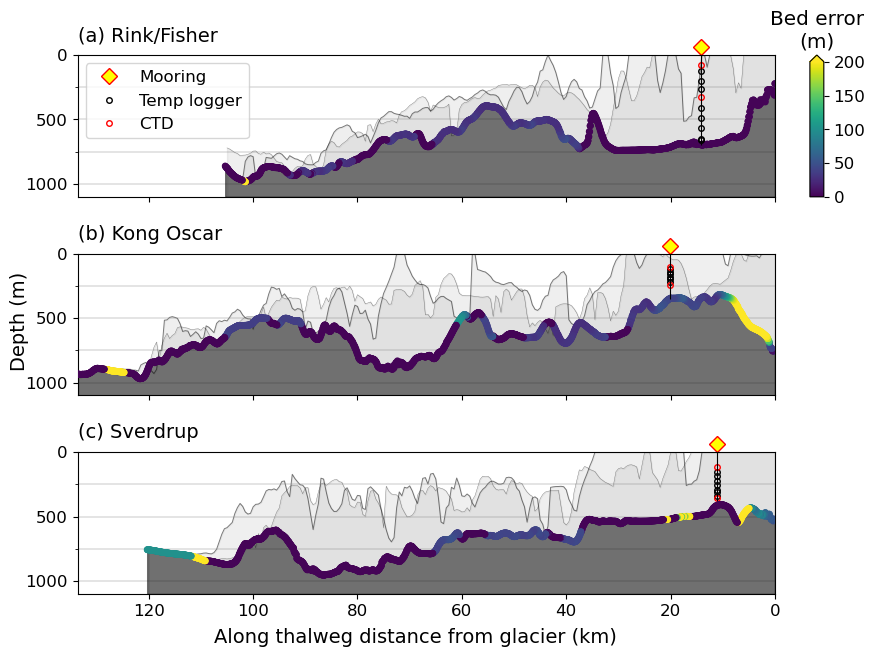

In [28]:
# provide a maximum depth for the figure (below the bathy line)
max_depth = 1100

plt.rcParams['font.size'] = '12'
fig, axs = plt.subplots(nrows=3, ncols=1, sharey=True, sharex=True,figsize=[9,7])
(ax1,ax2,ax3) = axs.ravel()
plt.subplots_adjust(wspace=0.1, hspace=0.4)

## ax1 functions ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
transect_csv_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/bathymetry/QGIS_files/rink_thalweg.csv')

for year in [2016,2018,2019,2020,2021]:
    ctds_transect_ds, transect_name, mooring_coords = get_thalweg_ctds('Rink', year, AXCTD_binned_dir, mooring_locations_dir, ship_CTD_binned_dir)
    ctds_transect_ds_xy = transform_projection_to_polar(ctds_transect_ds)
    ctd_distances_along_transect, max_seafloor, transect_points_df = assign_ctds_to_points_on_transect(transect_csv_dir)
    
## add mooring location to plot
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413')
x, y = transformer.transform(mooring_coords.lat, mooring_coords.lon)
distance = ((transect_points_df.x.values-x)**2 + (transect_points_df.y.values-y)**2)**0.5
index = np.argmin(distance) # index for at what distance along transect the mooring is located
ax1.plot(transect_points_df.distance.values[index],-60,'D',markerfacecolor='yellow',markeredgecolor='r',markersize=8, clip_on=False,label='Mooring')
ax1.vlines(transect_points_df.distance.values[index],ymin=transect_points_df.Bed_meters.values[index],ymax=0,colors='k',linestyles='-',linewidths=0.8,zorder=6) # original linestyles=":"
# add sensors to mooring vertical line
ax1.plot(([transect_points_df.distance.values[index]]*8),\
         (125,203,266,408,488,568,648,658),"o",markersize=4,markeredgecolor='k',markerfacecolor='None',zorder=5,label='Temp logger')
ax1.plot(([transect_points_df.distance.values[index]]*2),\
         (76,328),"o",markersize=4,markeredgecolor='r',markerfacecolor='None',zorder=5,label='CTD')
ax1.legend() # add legend

ax1.set_xlim(max(transect_points_df.distance),0)

# add bathymetry layer in gray
ax1.fill_between(transect_points_df.distance, transect_points_df.Bed_meters, max_depth, color='k', alpha=0.5, zorder=2)

## add bathymetry line colored by error
ax1.scatter(transect_points_df.distance, transect_points_df.Bed_meters,\
            c=transect_points_df.Errbed,vmin=0,vmax=200,s=15,zorder=4)

# add ridgeline ---------------------------------------------------------
ridgeline_plus_ds = xr.open_dataset(ridgeline_dir + 'rink' + '_ridgeline_plus.nc')
ridgeline_minus_ds = xr.open_dataset(ridgeline_dir + 'rink' + '_ridgeline_minus.nc')

# plot ridgeline
# plus in background
ax1.fill_between(ridgeline_plus_ds.distance/1000, ridgeline_plus_ds.ridgeline_plus.values*(-1), max_depth, color='dimgray', alpha=0.1)
ax1.plot(ridgeline_plus_ds.distance/1000, ridgeline_plus_ds.ridgeline_plus.values*(-1),'k',linewidth=0.3,zorder=1, alpha=0.5)
# minus in foreground
ax1.fill_between(ridgeline_minus_ds.distance/1000, ridgeline_minus_ds.ridgeline_minus.values*(-1), max_depth, color='dimgray', alpha=0.1)
ax1.plot(ridgeline_minus_ds.distance/1000, ridgeline_minus_ds.ridgeline_minus.values*(-1),'k',linewidth=0.7,zorder=1, alpha=0.5)
ax1.set_xlim(max(transect_points_df.distance),0)
ax1.set_ylim(max_depth,0)

## ax2 functions ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
transect_csv_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/bathymetry/QGIS_files/kongoscar_thalweg.csv')

for year in [2016,2017,2018,2019,2020,2021]:
    ctds_transect_ds, transect_name, mooring_coords = get_thalweg_ctds('Kong Oscar', year, AXCTD_binned_dir, mooring_locations_dir, ship_CTD_binned_dir)
    ctds_transect_ds_xy = transform_projection_to_polar(ctds_transect_ds)
    ctd_distances_along_transect, max_seafloor, transect_points_df = assign_ctds_to_points_on_transect(transect_csv_dir)
    
## add mooring location to plot
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413')
x, y = transformer.transform(mooring_coords.lat, mooring_coords.lon)
distance = ((transect_points_df.x.values-x)**2 + (transect_points_df.y.values-y)**2)**0.5
index = np.argmin(distance) # index for at what distance along transect the mooring is located
ax2.plot(transect_points_df.distance.values[index],-60,'D',markerfacecolor='yellow',markeredgecolor='r',markersize=8, clip_on=False)
ax2.vlines(transect_points_df.distance.values[index],ymin=transect_points_df.Bed_meters.values[index],ymax=0,colors='k',linestyles='-',linewidths=0.8,zorder=6) # original linestyles=":"
# add sensors to mooring vertical line
ax2.plot(([transect_points_df.distance.values[index]]*6),\
         (123,143,162,182,201,220),"o",color='k',markersize=4,markeredgecolor='k',markerfacecolor='None',zorder=5)
ax2.plot(([transect_points_df.distance.values[index]]*2),\
         (104,240),"o",color='r',markersize=4,markeredgecolor='r',markerfacecolor='None',zorder=5)

ax2.set_xlim(max(transect_points_df.distance),0)

# add bathymetry layer in gray
ax2.fill_between(transect_points_df.distance, transect_points_df.Bed_meters, max_depth, color='k', alpha=0.5, zorder=2)

## add bathymetry line colored by error
error_cb = ax2.scatter(transect_points_df.distance, transect_points_df.Bed_meters,\
                       c=transect_points_df.Errbed,vmin=0,vmax=200,s=15,zorder=4)

## add colorbar
axins = inset_axes(
    ax1,
    width="2%",  # width: x% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.05, 0., 1, 1),
    bbox_transform=ax1.transAxes,
    borderpad=0)
cb = fig.colorbar(error_cb, cax=axins, ticks=np.arange(0,250,50), extend='max')
cb.ax.set_title("Bed error\n(m)")

kong_distance_max = transect_points_df.distance.max()

# add ridgeline ---------------------------------------------------------
ridgeline_plus_ds = xr.open_dataset(ridgeline_dir + 'kongoscar' + '_ridgeline_plus.nc')
ridgeline_minus_ds = xr.open_dataset(ridgeline_dir + 'kongoscar' + '_ridgeline_minus.nc')

# plot ridgeline
# plus in background
ax2.fill_between(ridgeline_plus_ds.distance/1000, ridgeline_plus_ds.ridgeline_plus.values*(-1), max_depth, color='dimgray', alpha=0.1)
ax2.plot(ridgeline_plus_ds.distance/1000, ridgeline_plus_ds.ridgeline_plus.values*(-1),'k',linewidth=0.3,zorder=1, alpha=0.5)
# minus in foreground
ax2.fill_between(ridgeline_minus_ds.distance/1000, ridgeline_minus_ds.ridgeline_minus.values*(-1), max_depth, color='dimgray', alpha=0.1)
ax2.plot(ridgeline_minus_ds.distance/1000, ridgeline_minus_ds.ridgeline_minus.values*(-1),'k',linewidth=0.7,zorder=1, alpha=0.5)
ax2.set_xlim(max(transect_points_df.distance),0)
ax2.set_ylim(max_depth,0)
   
## ax3 functions ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
transect_csv_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/bathymetry/QGIS_files/sverdrup_thalweg.csv')

for year in [2016,2017,2018,2019,2020,2021]:
    ctds_transect_ds, transect_name, mooring_coords = get_thalweg_ctds('Sverdrup', year, AXCTD_binned_dir, mooring_locations_dir, ship_CTD_binned_dir)
    ctds_transect_ds_xy = transform_projection_to_polar(ctds_transect_ds)
    ctd_distances_along_transect, max_seafloor, transect_points_df = assign_ctds_to_points_on_transect(transect_csv_dir)

## add mooring location to plot
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413')
x, y = transformer.transform(mooring_coords.lat, mooring_coords.lon)
distance = ((transect_points_df.x.values-x)**2 + (transect_points_df.y.values-y)**2)**0.5
index = np.argmin(distance) # index for at what distance along transect the mooring is located
ax3.plot(transect_points_df.distance.values[index],-60,'D',markerfacecolor='yellow',markeredgecolor='r',markersize=8, clip_on=False)
ax3.vlines(transect_points_df.distance.values[index],ymin=transect_points_df.Bed_meters.values[index],ymax=0,colors='k',linestyles='-',linewidths=0.8,zorder=6) # original linestyles=":"
# add sensors to mooring vertical line
ax3.plot(([transect_points_df.distance.values[index]]*7),\
         (153,188,223,258,293,311,337),"o",markersize=4,markeredgecolor='k',markerfacecolor='None',zorder=5)
ax3.plot(([transect_points_df.distance.values[index]]*2),\
         (118,355),"o",markersize=4,markeredgecolor='r',markerfacecolor='None',zorder=5)

# add bathymetry layer in gray
ax3.fill_between(transect_points_df.distance, transect_points_df.Bed_meters, max_depth, color='k', alpha=0.5, zorder=2)

## add bathymetry line colored by error
ax3.scatter(transect_points_df.distance, transect_points_df.Bed_meters,\
            c=transect_points_df.Errbed,vmin=0,vmax=200,s=15,zorder=15)

# add ridgeline ---------------------------------------------------------
ridgeline_plus_ds = xr.open_dataset(ridgeline_dir + 'sverdrup' + '_ridgeline_plus.nc')
ridgeline_minus_ds = xr.open_dataset(ridgeline_dir + 'sverdrup' + '_ridgeline_minus.nc')

# plot ridgeline
# plus in background
ax3.fill_between(ridgeline_plus_ds.distance/1000, ridgeline_plus_ds.ridgeline_plus.values*(-1), max_depth, color='dimgray', alpha=0.1)
ax3.plot(ridgeline_plus_ds.distance/1000, ridgeline_plus_ds.ridgeline_plus.values*(-1),'k',linewidth=0.3,zorder=1, alpha=0.5)
# minus in foreground
ax3.fill_between(ridgeline_minus_ds.distance/1000, ridgeline_minus_ds.ridgeline_minus.values*(-1), max_depth, color='dimgray', alpha=0.1)
ax3.plot(ridgeline_minus_ds.distance/1000, ridgeline_minus_ds.ridgeline_minus.values*(-1),'k',linewidth=0.7,zorder=1, alpha=0.5)
ax3.set_xlim(max(transect_points_df.distance),0)
ax3.set_ylim(max_depth,0)

# adjust settings in plot and add labels -------------------------------
labels = ["(a) Rink/Fisher","(b) Kong Oscar","(c) Sverdrup"]
for (ax,label) in zip((ax1,ax2,ax3),labels):
    ax.margins(x=0,y=0)
    ax.set_ylim(max_depth,0)
    ax.text(0, 1.1, label, ha='left',size=14,transform=ax.transAxes)

fig.text(0.5, 0.04, 'Along thalweg distance from glacier (km)', size=14, ha='center')
fig.text(0.05, 0.5, 'Depth (m)', size=14, va='center', rotation='vertical');

# add gridlines
for ax in [ax1,ax2,ax3]:
    ax.set_xlim(kong_distance_max,0)
    ax.set_yticks([0, 500, 1000], minor=False)
    ax.set_yticks([250, 750], minor=True)
    ax.yaxis.grid(which='both',linestyle='-',linewidth=0.3,color='gray')

# save png file
plt.savefig("figures/CTD_transect_multipanel_supplement.png",bbox_inches='tight', dpi=300, facecolor='white')

plt.show()

Add AXCTD locations and depths to compare to bathymetry

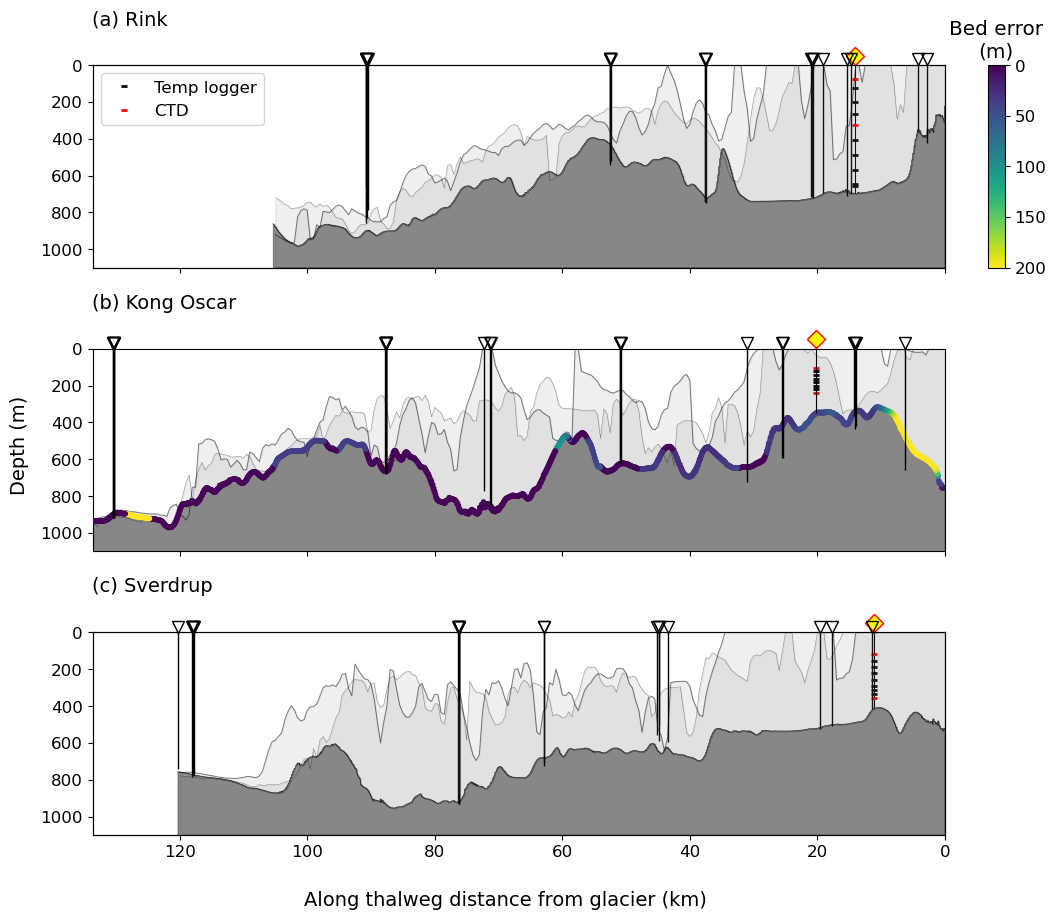

In [80]:
# provide a maximum depth for the figure (below the bathy line)
max_depth = 1100

plt.rcParams['font.size'] = '12'
fig, axs = plt.subplots(nrows=3, ncols=1, sharey=True, sharex=True,figsize=[11,10])
(ax1,ax2,ax3) = axs.ravel()
plt.subplots_adjust(wspace=0.1, hspace=0.4)

## ax1 functions ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
transect_csv_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/bathymetry/QGIS_files/rink_thalweg.csv')

for year in [2016,2018,2019,2020,2021]:
    ctds_transect_ds, transect_name, mooring_coords = get_thalweg_ctds('Rink', year, AXCTD_binned_dir, mooring_locations_dir, ship_CTD_binned_dir)
    ctds_transect_ds_xy = transform_projection_to_polar(ctds_transect_ds)
    ctd_distances_along_transect, max_seafloor, transect_points_df = assign_ctds_to_points_on_transect(transect_csv_dir)
    temp_da_interp, salt_da_interp, density_DA_new_at_interpolation_depths = interpolate_profile_along_transect(ctds_transect_ds_xy, transect_points_df)
    
    # add 'month-day' text to each CTD profile point
    # for i in range(len(ctds_transect_ds_xy.time.values)):
    #     date_tmp = np.datetime_as_string(ctds_transect_ds_xy.time.values[i])[5:10] + "-" + np.datetime_as_string(ctds_transect_ds_xy.time.values[i])[2:4]
    #     ax1.annotate(date_tmp, (ctds_transect_ds_xy.distance.values[i]+1, -65), rotation=45, size=10, ha='left', va='bottom',annotation_clip=False)
        
    # add points and lines to mark locations of ctd profiles -----------------------------------------------------------
    for i in range(len(ctd_distances_along_transect)):
        if ctds_transect_ds_xy.isel(time=i).ctd_type.values == 'axctd':
            ax1.plot(ctd_distances_along_transect[i],-30,'kv', markerfacecolor="None", markersize=8, clip_on=False,zorder=3)
            # obtain the maximum depths for each axctd so vertical lines can be plotted for each profile (to show how much was interpolated)
            profile_max_depth = ctds_transect_ds_xy.max_depth.isel(time=i).values
            # add vertical lines for each CTD profile
            ax1.vlines(ctd_distances_along_transect[i],ymin=profile_max_depth,ymax=0,colors='k',linestyles='-',linewidths=1,zorder=3)
    
## add mooring location to plot
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413')
x, y = transformer.transform(mooring_coords.lat, mooring_coords.lon)
distance = ((transect_points_df.x.values-x)**2 + (transect_points_df.y.values-y)**2)**0.5
index = np.argmin(distance) # index for at what distance along transect the mooring is located
ax1.plot(transect_points_df.distance.values[index],-50,'D',markerfacecolor='yellow',markeredgecolor='r',markersize=9, clip_on=False)
ax1.vlines(transect_points_df.distance.values[index],ymin=transect_points_df.Bed_meters.values[index],ymax=0,colors='k',linestyles='-',linewidths=0.8,zorder=2) # original linestyles=":"
# ax1.plot((transect_points_df.distance.values[index],transect_points_df.distance.values[index]),\
#          (76,658),"_",color='r',markersize=13,markeredgewidth=2,zorder=5)

ax1.plot(([transect_points_df.distance.values[index]]*8),\
         (125,203,266,408,488,568,648,658),"_",color='k',markersize=4,markeredgewidth=2,zorder=5,label='Temp logger')
ax1.plot(([transect_points_df.distance.values[index]]*2),\
         (76,328),"_",color='r',markersize=4,markeredgewidth=2,zorder=5,label='CTD')
ax1.legend()

ax1.set_xlim(max(transect_points_df.distance),0)

# add bathymetry layer in gray
ax1_twin=ax1.twinx()
ax1_twin.fill_between(transect_points_df.distance, transect_points_df.Bed_meters, max_depth, color='k', alpha=0.4, zorder=2)
ax1_twin.plot(transect_points_df.distance, transect_points_df.Bed_meters,'k',linewidth=0.3,zorder=2)

# add ridgeline ---------------------------------------------------------
ridgeline_plus_ds = xr.open_dataset(ridgeline_dir + 'rink' + '_ridgeline_plus.nc')
ridgeline_minus_ds = xr.open_dataset(ridgeline_dir + 'rink' + '_ridgeline_minus.nc')

# plot ridgeline
# plus in background
ax1_twin.fill_between(ridgeline_plus_ds.distance/1000, ridgeline_plus_ds.ridgeline_plus.values*(-1), max_depth, color='dimgray', alpha=0.1)
ax1_twin.plot(ridgeline_plus_ds.distance/1000, ridgeline_plus_ds.ridgeline_plus.values*(-1),'k',linewidth=0.3,zorder=1, alpha=0.5)
# minus in foreground
ax1_twin.fill_between(ridgeline_minus_ds.distance/1000, ridgeline_minus_ds.ridgeline_minus.values*(-1), max_depth, color='dimgray', alpha=0.1)
ax1_twin.plot(ridgeline_minus_ds.distance/1000, ridgeline_minus_ds.ridgeline_minus.values*(-1),'k',linewidth=0.7,zorder=1, alpha=0.5)
ax1_twin.set_xlim(max(transect_points_df.distance),0)
ax1_twin.set_ylim(max_depth,0)
ax1_twin.xaxis.set_visible(False)
ax1_twin.yaxis.set_visible(False)

## ax2 functions ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
transect_csv_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/bathymetry/QGIS_files/kongoscar_thalweg_w-error.csv')

for year in [2016,2017,2018,2019,2020,2021]:
    ctds_transect_ds, transect_name, mooring_coords = get_thalweg_ctds('Kong Oscar', year, AXCTD_binned_dir, mooring_locations_dir, ship_CTD_binned_dir)
    ctds_transect_ds_xy = transform_projection_to_polar(ctds_transect_ds)
    ctd_distances_along_transect, max_seafloor, transect_points_df = assign_ctds_to_points_on_transect(transect_csv_dir)
    temp_da_interp, salt_da_interp, density_DA_new_at_interpolation_depths = interpolate_profile_along_transect(ctds_transect_ds_xy, transect_points_df)
    
    # add points and lines to mark locations of ctd profiles -----------------------------------------------------------
    for i in range(len(ctd_distances_along_transect)):
        if ctds_transect_ds_xy.isel(time=i).ctd_type.values == 'axctd':
            ax2.plot(ctd_distances_along_transect[i],-30,'kv', markerfacecolor="None", markersize=8, clip_on=False,zorder=3)
            # obtain the maximum depths for each axctd so vertical lines can be plotted for each profile (to show how much was interpolated)
            profile_max_depth = ctds_transect_ds_xy.max_depth.isel(time=i).values
            # add vertical lines for each CTD profile
            ax2.vlines(ctd_distances_along_transect[i],ymin=profile_max_depth,ymax=0,colors='k',linestyles='-',linewidths=1,zorder=6)
    
## add mooring location to plot
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413')
x, y = transformer.transform(mooring_coords.lat, mooring_coords.lon)
distance = ((transect_points_df.x.values-x)**2 + (transect_points_df.y.values-y)**2)**0.5
index = np.argmin(distance) # index for at what distance along transect the mooring is located
ax2.plot(transect_points_df.distance.values[index],-50,'D',markerfacecolor='yellow',markeredgecolor='r',markersize=9, clip_on=False)
ax2.vlines(transect_points_df.distance.values[index],ymin=transect_points_df.Bed_meters.values[index],ymax=0,colors='k',linestyles='-',linewidths=0.8,zorder=6) # original linestyles=":"
# ax2.plot((transect_points_df.distance.values[index],transect_points_df.distance.values[index]),\
#          (104,220),"_",color='r',markersize=13,markeredgewidth=2,zorder=5)
    
ax2.plot(([transect_points_df.distance.values[index]]*6),\
         (123,143,162,182,201,220),"_",color='k',markersize=4,markeredgewidth=2,zorder=5)
ax2.plot(([transect_points_df.distance.values[index]]*2),\
         (104,240),"_",color='r',markersize=4,markeredgewidth=2,zorder=5)

ax2.set_xlim(max(transect_points_df.distance),0)

# add bathymetry layer in gray
ax2.fill_between(transect_points_df.distance, transect_points_df.Bed_meters, max_depth, color='k', alpha=0.4, zorder=2)
# ax2_twin.plot(transect_points_df.distance, transect_points_df.Bed_meters,'k',linewidth=0.3,zorder=2)
## add bathymetry line colored by error
error_cb = ax2.scatter(transect_points_df.distance, transect_points_df.Bed_meters, c=transect_points_df.bed_error1,vmin=0,vmax=200,s=8,alpha=1,zorder=4)

## add colorbar
axins = inset_axes(
    ax1,
    width="2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.05, 0., 1, 1),
    bbox_transform=ax1.transAxes,
    borderpad=0)
cb = fig.colorbar(error_cb, cax=axins)
# cb.ax.set_yticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
cb.ax.set_title("Bed error\n(m)")
cb.ax.invert_yaxis()

kong_distance_max = transect_points_df.distance.max()

# add ridgeline ---------------------------------------------------------
ridgeline_plus_ds = xr.open_dataset(ridgeline_dir + 'kongoscar' + '_ridgeline_plus.nc')
ridgeline_minus_ds = xr.open_dataset(ridgeline_dir + 'kongoscar' + '_ridgeline_minus.nc')

# plot ridgeline
# plus in background
ax2.fill_between(ridgeline_plus_ds.distance/1000, ridgeline_plus_ds.ridgeline_plus.values*(-1), max_depth, color='dimgray', alpha=0.1)
ax2.plot(ridgeline_plus_ds.distance/1000, ridgeline_plus_ds.ridgeline_plus.values*(-1),'k',linewidth=0.3,zorder=1, alpha=0.5)
# minus in foreground
ax2.fill_between(ridgeline_minus_ds.distance/1000, ridgeline_minus_ds.ridgeline_minus.values*(-1), max_depth, color='dimgray', alpha=0.1)
ax2.plot(ridgeline_minus_ds.distance/1000, ridgeline_minus_ds.ridgeline_minus.values*(-1),'k',linewidth=0.7,zorder=1, alpha=0.5)
ax2.set_xlim(max(transect_points_df.distance),0)
ax2.set_ylim(max_depth,0)
# ax2.xaxis.set_visible(False)
# ax2.yaxis.set_visible(False)
   
## ax3 functions ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
transect_csv_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/bathymetry/QGIS_files/sverdrup_thalweg.csv')

for year in [2016,2017,2018,2019,2020,2021]:
    ctds_transect_ds, transect_name, mooring_coords = get_thalweg_ctds('Sverdrup', year, AXCTD_binned_dir, mooring_locations_dir, ship_CTD_binned_dir)
    ctds_transect_ds_xy = transform_projection_to_polar(ctds_transect_ds)
    ctd_distances_along_transect, max_seafloor, transect_points_df = assign_ctds_to_points_on_transect(transect_csv_dir)
    temp_da_interp, salt_da_interp, density_DA_new_at_interpolation_depths = interpolate_profile_along_transect(ctds_transect_ds_xy, transect_points_df)
    
    # add points and lines to mark locations of ctd profiles -----------------------------------------------------------
    for i in range(len(ctd_distances_along_transect)):
        if ctds_transect_ds_xy.isel(time=i).ctd_type.values == 'axctd':
            ax3.plot(ctd_distances_along_transect[i],-30,'kv', markerfacecolor="None", markersize=8, clip_on=False,zorder=3)
            # obtain the maximum depths for each axctd so vertical lines can be plotted for each profile (to show how much was interpolated)
            profile_max_depth = ctds_transect_ds_xy.max_depth.isel(time=i).values
            # add vertical lines for each CTD profile
            ax3.vlines(ctd_distances_along_transect[i],ymin=profile_max_depth,ymax=0,colors='k',linestyles='-',linewidths=1,zorder=10)
            
## add mooring location to plot
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413')
x, y = transformer.transform(mooring_coords.lat, mooring_coords.lon)
distance = ((transect_points_df.x.values-x)**2 + (transect_points_df.y.values-y)**2)**0.5
index = np.argmin(distance) # index for at what distance along transect the mooring is located
ax3.plot(transect_points_df.distance.values[index],-50,'D',markerfacecolor='yellow',markeredgecolor='r',markersize=9, clip_on=False)
ax3.vlines(transect_points_df.distance.values[index],ymin=transect_points_df.Bed_meters.values[index],ymax=0,colors='k',linestyles='-',linewidths=0.8,zorder=2) # original linestyles=":"
# ax3.plot((transect_points_df.distance.values[index],transect_points_df.distance.values[index]),\
#          (118,337),"_",color='r',markersize=13,markeredgewidth=2,zorder=5)

ax3.plot(([transect_points_df.distance.values[index]]*7),\
         (153,188,223,258,293,311,337),"_",color='k',markersize=4,markeredgewidth=2,zorder=5)
ax3.plot(([transect_points_df.distance.values[index]]*2),\
         (118,355),"_",color='r',markersize=4,markeredgewidth=2,zorder=5)

# add bathymetry layer in gray
ax3_twin=ax3.twinx()
ax3_twin.fill_between(transect_points_df.distance, transect_points_df.Bed_meters, max_depth, color='k', alpha=0.4, zorder=2)
ax3_twin.plot(transect_points_df.distance, transect_points_df.Bed_meters,'k',linewidth=0.3,zorder=2)

# add ridgeline ---------------------------------------------------------
ridgeline_plus_ds = xr.open_dataset(ridgeline_dir + 'sverdrup' + '_ridgeline_plus.nc')
ridgeline_minus_ds = xr.open_dataset(ridgeline_dir + 'sverdrup' + '_ridgeline_minus.nc')

# plot ridgeline
# plus in background
ax3_twin.fill_between(ridgeline_plus_ds.distance/1000, ridgeline_plus_ds.ridgeline_plus.values*(-1), max_depth, color='dimgray', alpha=0.1)
ax3_twin.plot(ridgeline_plus_ds.distance/1000, ridgeline_plus_ds.ridgeline_plus.values*(-1),'k',linewidth=0.3,zorder=1, alpha=0.5)
# minus in foreground
ax3_twin.fill_between(ridgeline_minus_ds.distance/1000, ridgeline_minus_ds.ridgeline_minus.values*(-1), max_depth, color='dimgray', alpha=0.1)
ax3_twin.plot(ridgeline_minus_ds.distance/1000, ridgeline_minus_ds.ridgeline_minus.values*(-1),'k',linewidth=0.7,zorder=1, alpha=0.5)
ax3_twin.set_xlim(max(transect_points_df.distance),0)
ax3_twin.set_ylim(max_depth,0)
ax3_twin.xaxis.set_visible(False)
ax3_twin.yaxis.set_visible(False)

# adjust settings in plot and add labels -------------------------------
labels = ["(a) Rink","(b) Kong Oscar","(c) Sverdrup"]
for (ax,label) in zip((ax1,ax2,ax3),labels):
    ax.margins(x=0,y=0)
    ax.set_ylim(max_depth,0)
    ax.text(0, 1.2, label, ha='left',size=14,transform=ax.transAxes)

fig.text(0.5, 0.04, 'Along thalweg distance from glacier (km)', size=14, ha='center')
fig.text(0.05, 0.5, 'Depth (m)', size=14, va='center', rotation='vertical');

# save png file
# plt.savefig("figures/CTD_transect_multipanel.png",bbox_inches='tight', dpi=300, facecolor='white')

ax3.set_xlim(kong_distance_max,0)

plt.show()

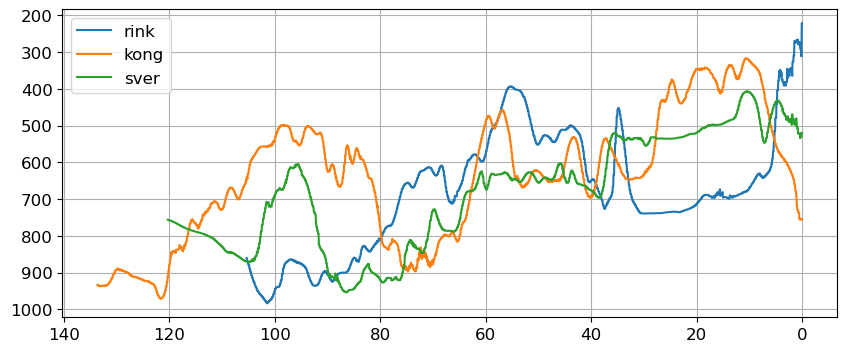

In [17]:
# plot all thalwegs on same plot
plt.figure(figsize=(10,4))
plt.plot(rink_transect.distance, rink_transect.Bed_meters, label='rink')
plt.plot(kong_transect.distance, kong_transect.Bed_meters, label='kong')
plt.plot(sver_transect.distance, sver_transect.Bed_meters, label='sver')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# rink
# plt.axhline(y=393, color='k')
# plt.axhline(y=447, color='k')

# kong oscar
# plt.axhline(y=317, color='k')
# plt.axhline(y=458, color='k')
# plt.axhline(y=497, color='k')

# sverdrup
# plt.axhline(y=407, color='k')
# plt.axhline(y=606, color='k')

plt.legend()
plt.grid()